In [1]:
import os
import shutil
import cv2
import torch
import albumentations as albu
import numpy as np
from pylab import imshow
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import random
import mediapipe as mp
import math
from rembg import remove 
from iglovikov_helper_functions.utils.image_utils import load_rgb, pad, unpad
from iglovikov_helper_functions.dl.pytorch.utils import tensor_from_rgb_image
from cloths_segmentation.pre_trained_models import create_model

model = create_model("Unet_2020-10-30")
model.eval();

c:\Users\THU\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\hub.py:682: UserWarning: Falling back to the old format < 1.6. This support will be deprecated in favor of default zipfile format introduced in 1.6. Please redo torch.save() to save it in the new zipfile format.
  warnings.warn('Falling back to the old format < 1.6. This support will be '


In [ ]:
image_links = [f for f in os.listdir('D:\\Datathon\\DM-VTON_new\\dataset\\VITON-Clean\\VITON_test\\Cloth')]
image_links

In [5]:
def preprocessing_cloth_mask():
    """
    Preprocessing Image and Cloth with:
    + Remove background
    + Create mask for cloth
    + Resize and padding if needed
    """
    
    # Create Path (Change data_folder if needed)
    image_names = [f for f in os.listdir('D:\\Datathon\\DM-VTON_new\\dataset\\VITON-Clean\\VITON_test\\Cloth')]
    data_folder = 'D:\\Datathon\\DM-VTON_new\\dataset\\VITON-Clean\\VITON_test'
    for image_name in image_names:
        # Create mask for Color
        color_path = os.path.join(data_folder, "Cloth", image_name)
        edge_path = os.path.join(data_folder, "resize_mask", image_name)
        image = load_rgb(color_path)
        if image.shape != (256,192,3):
            transform = albu.Compose([albu.Normalize(p=1)], p=1)
            padded_image, pads = pad(image, factor=32, border=cv2.BORDER_CONSTANT)
            x = transform(image=padded_image)["image"]
            x = torch.unsqueeze(tensor_from_rgb_image(x), 0)
            with torch.no_grad():
                prediction = model(x)[0][0]
            mask = (prediction > 0).cpu().numpy().astype(np.uint8)
            mask = unpad(mask, pads)
            cv2.imwrite(edge_path, cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB) * 255)
        

        # Resize Color and Edge
        expected_size = (192,256)
        edge = cv2.imread(os.path.join(data_folder, "resize_mask", image_name))
        color = cv2.imread(os.path.join(data_folder, "Cloth", image_name))
        if edge.shape != (256,192,3):
            blurred = cv2.blur(edge, (3,3))
            canny = cv2.Canny(blurred, 50, 200)
            pts = np.argwhere(canny>0)
            y1,x1 = pts.min(axis=0)
            y2,x2 = pts.max(axis=0)     
            edge = edge[y1-20:y2+20, x1-15:x2+15]
            color = color[y1-20:y2+20, x1-15:x2+15]
            edge = Image.fromarray(cv2.cvtColor(edge, cv2.COLOR_BGR2RGB))
            color = Image.fromarray(cv2.cvtColor(color, cv2.COLOR_BGR2RGB))
            edge.thumbnail((expected_size[0], expected_size[1]))
            color.thumbnail((expected_size[0], expected_size[1]))
            delta_width = expected_size[0] - edge.size[0]
            delta_height = expected_size[1] - edge.size[1]
            pad_width = delta_width // 2
            pad_height = delta_height // 2
            padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
            edge = ImageOps.expand(edge, padding, fill = (0, 0, 0))
            color = ImageOps.expand(color, padding, fill = (234, 238, 239))
            edge.save(os.path.join(data_folder, "resize_mask", image_name))
            color.save(os.path.join(data_folder, "resize_cloth", image_name))


In [6]:
preprocessing_cloth_mask()

In [2]:

model = create_model("Unet_2020-10-30")
model.eval();

def calculate_angle(a, b, c):
  cosine_angle = abs(
        (a.x - b.x) * (c.x - b.x) + (a.y - b.y) * (c.y - b.y)
    ) / (
        ((a.x - b.x) ** 2 + (a.y - b.y) ** 2) ** 0.5 * ((c.x - b.x) ** 2 + (c.y - b.y) ** 2) ** 0.5
    )
  return np.degrees(np.arccos(cosine_angle))

def is_arm_straight(landmarks):
    # Get the landmarks for the shoulder, elbow, and wrist
    left_shoulder = landmarks[mp.solutions.pose.PoseLandmark.LEFT_SHOULDER.value]
    left_elbow = landmarks[mp.solutions.pose.PoseLandmark.LEFT_ELBOW.value]
    left_wrist = landmarks[mp.solutions.pose.PoseLandmark.LEFT_WRIST.value]
    left_angle = calculate_angle(left_shoulder, left_elbow, left_wrist)
    right_shoulder = landmarks[mp.solutions.pose.PoseLandmark.RIGHT_SHOULDER.value]
    right_elbow = landmarks[mp.solutions.pose.PoseLandmark.RIGHT_ELBOW.value]
    right_wrist = landmarks[mp.solutions.pose.PoseLandmark.RIGHT_WRIST.value]
    right_angle = calculate_angle(right_shoulder, right_elbow, right_wrist)
    # Define a threshold for what constitutes a straight hand
    straight_threshold = 150  # You might need to adjust this value based on your use case
    # Check if the angle is within the threshold
    left_flag = (left_angle > straight_threshold) or (left_angle < 180 - straight_threshold)
    right_flag = (right_angle > straight_threshold) or (right_angle < 180 - straight_threshold)
    return left_flag and right_flag

def check_arm_straight(image_path):
  # Initialize MediaPipe Pose
  mp_pose = mp.solutions.pose
  pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5, min_tracking_confidence=0.5)
  # Read an image
  image = cv2.imread(image_path)
  # Process the image
  results = pose.process(image)
  if results.pose_landmarks:
    landmarks = results.pose_landmarks.landmark
    return is_arm_straight(landmarks)
  return -1 #Error

def preprocessing(img_name = "000001_1.jpg", color_name = "000001_0.jpg"):
    """
    Preprocessing Image and Cloth with:
    + Remove background
    + Create mask for cloth
    + Resize and padding if needed
    """

    # Create Path (Change data_folder if needed)
    data_folder = '../dataset/VITON-Clean/VITON_test'
    color_path = os.path.join(data_folder, "test_color", color_name)
    edge_path = os.path.join(data_folder, "test_edge", color_name)
    img_path = os.path.join(data_folder, "test_img", img_name)

    # Remove background of Image
    input = Image.open(img_path) 
    output = remove(input, bgcolor = (255,255,255,0)).convert('RGB')  
    output.save(img_path)

    # Create mask for Color
    image = load_rgb(color_path)
    if image.shape != (256,192,3):
      transform = albu.Compose([albu.Normalize(p=1)], p=1)
      padded_image, pads = pad(image, factor=32, border=cv2.BORDER_CONSTANT)
      x = transform(image=padded_image)["image"]
      x = torch.unsqueeze(tensor_from_rgb_image(x), 0)
      with torch.no_grad():
          prediction = model(x)[0][0]
      mask = (prediction > 0).cpu().numpy().astype(np.uint8)
      mask = unpad(mask, pads)
      cv2.imwrite(edge_path, cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB) * 255)

    # Resize Color and Edge
    expected_size = (192,256)
    edge = cv2.imread(edge_path)
    color = cv2.imread(color_path)
    if edge.shape != (256,192,3):
        blurred = cv2.blur(edge, (3,3))
        canny = cv2.Canny(blurred, 50, 200)
        pts = np.argwhere(canny>0)
        y1,x1 = pts.min(axis=0)
        y2,x2 = pts.max(axis=0)     
        edge = edge[y1-20:y2+20, x1-15:x2+15]
        color = color[y1-20:y2+20, x1-15:x2+15]
        edge = Image.fromarray(cv2.cvtColor(edge, cv2.COLOR_BGR2RGB))
        color = Image.fromarray(cv2.cvtColor(color, cv2.COLOR_BGR2RGB))
        edge.thumbnail((expected_size[0], expected_size[1]))
        color.thumbnail((expected_size[0], expected_size[1]))
        delta_width = expected_size[0] - edge.size[0]
        delta_height = expected_size[1] - edge.size[1]
        pad_width = delta_width // 2
        pad_height = delta_height // 2
        padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
        edge = ImageOps.expand(edge, padding, fill = (0, 0, 0))
        color = ImageOps.expand(color, padding, fill = (234, 238, 239))
        edge.save(edge_path)
        color.save(color_path)
    
    # Resize Image
    img = cv2.imread(img_path)
    if img.shape != (256,192,3):
        blurred = cv2.blur(img, (3,3))
        canny = cv2.Canny(blurred, 50, 200)
        pts = np.argwhere(canny>0)
        y1,x1 = pts.min(axis=0)
        y2,x2 = pts.max(axis=0)     
        img = img[y1-20:y2+20, x1-15:x2+15]
        img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        img.thumbnail((expected_size[0], expected_size[1]))
        delta_width = expected_size[0] - img.size[0]
        delta_height = expected_size[1] - img.size[1]
        pad_width = delta_width // 2
        pad_height = delta_height // 2
        padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
        img = ImageOps.expand(img, padding, fill = (255, 255, 255))
        img.save(img_path)

In [5]:
#%cd DMVTON
data_folder = '../dataset/VITON-Clean/VITON_test'
img_name = 'test_img.jpg'
image_path = os.path.join(data_folder,'test_img', img_name)

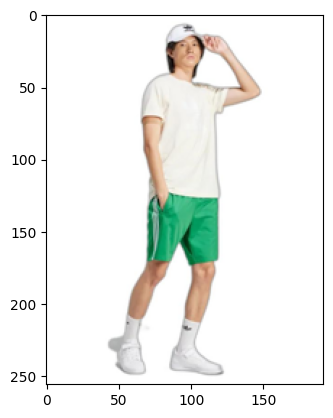

In [23]:
'''
input = Image.open(image_path) 
output = remove(input, bgcolor = (255,255,255,0)).convert('RGB')  
output.save(image_path)
'''
expected_size = (192,256)
img = cv2.imread(image_path)

if img.shape != (256,192,3):
    blurred = cv2.blur(img, (3,3))
    canny = cv2.Canny(blurred, 50, 200)
    pts = np.argwhere(canny>0)
    y1,x1 = pts.min(axis=0)
    y2,x2 = pts.max(axis=0)     
    img = img[y1-20:y2+20, x1-15:x2+15]
    img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    img.thumbnail((expected_size[0], expected_size[1]))
    delta_width = expected_size[0] - img.size[0]
    delta_height = expected_size[1] - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    img = ImageOps.expand(img, padding, fill = (255, 255, 255))
    img.save(os.path.join(data_folder,'test_img', 'preprocessing.jpg'))
    plt.imshow(img)

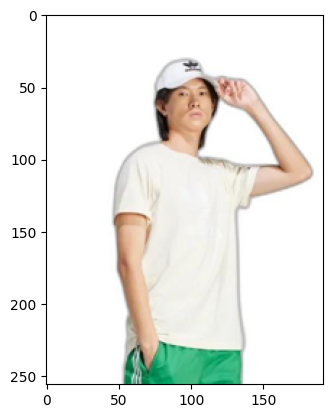

In [42]:
expected_size = (192,256)
img = cv2.imread(image_path)

blurred = cv2.blur(img, (3,3))
canny = cv2.Canny(blurred, 50, 200)
pts = np.argwhere(canny>0)
y1,x1 = pts.min(axis=0)
y2,x2 = pts.max(axis=0)
if 0: # Not full body
    img = img[y1-20:y2+20, x1-15:x2+15]
else: # Full body
    temp = int((y2-y1)*3/5)
    img = img[y1:temp, x1-15:x2+15]
img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
img.thumbnail((expected_size[0], expected_size[1]))
delta_width = expected_size[0] - img.size[0]
delta_height = expected_size[1] - img.size[1]
pad_width = delta_width // 2
pad_height = delta_height // 2
#padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
padding = (pad_width, pad_height*2, delta_width - pad_width, 0)
img = ImageOps.expand(img, padding, fill = (255, 255, 255))
plt.imshow(img)
img.save(os.path.join(data_folder,'test_img', 'preprocessing.jpg'))

In [41]:
pad_height

15

In [34]:
data_folder = '../dataset/VITON-Clean/VITON_test'
img_name = 'test_img.jpg'
image_path = os.path.join(data_folder,'test_img', img_name)
img = cv2.imread(image_path)
img.shape

(840, 840, 3)

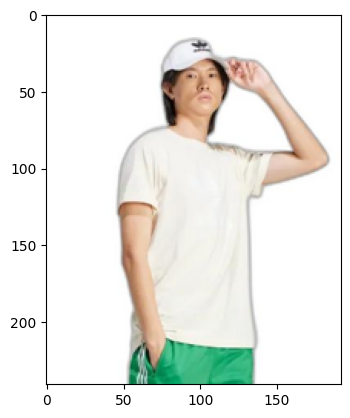

In [26]:
plt.imshow(img)

In [29]:
def calculate_angle(a, b, c):
  cosine_angle = abs(
        (a.x - b.x) * (c.x - b.x) + (a.y - b.y) * (c.y - b.y)
    ) / (
        ((a.x - b.x) ** 2 + (a.y - b.y) ** 2) ** 0.5 * ((c.x - b.x) ** 2 + (c.y - b.y) ** 2) ** 0.5
    )
  return np.degrees(np.arccos(cosine_angle))

def is_arm_straight(landmarks):
    # Get the landmarks for the shoulder, elbow, and wrist
    left_shoulder = landmarks[mp.solutions.pose.PoseLandmark.LEFT_SHOULDER.value]
    left_elbow = landmarks[mp.solutions.pose.PoseLandmark.LEFT_ELBOW.value]
    left_wrist = landmarks[mp.solutions.pose.PoseLandmark.LEFT_WRIST.value]
    left_angle = calculate_angle(left_shoulder, left_elbow, left_wrist)
    right_shoulder = landmarks[mp.solutions.pose.PoseLandmark.RIGHT_SHOULDER.value]
    right_elbow = landmarks[mp.solutions.pose.PoseLandmark.RIGHT_ELBOW.value]
    right_wrist = landmarks[mp.solutions.pose.PoseLandmark.RIGHT_WRIST.value]
    right_angle = calculate_angle(right_shoulder, right_elbow, right_wrist)
    print('Right', right_angle)
    print('Left', left_angle)
    # Define a threshold for what constitutes a straight hand
    straight_threshold = 150  # You might need to adjust this value based on your use case
    # Check if the angle is within the threshold
    left_flag = (left_angle > straight_threshold) or (left_angle < 180 - straight_threshold)
    right_flag = (right_angle > straight_threshold) or (right_angle < 180 - straight_threshold)
    return left_flag and right_flag

def check_arm_straight(image_path):
  # Initialize MediaPipe Pose
  mp_pose = mp.solutions.pose
  pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5, min_tracking_confidence=0.5)
  # Read an image
  image = cv2.imread(image_path)
  '''
  if image_path.endswith('.jpg'):
    jpg_image = cv2.imread(image_path)
    cv2.imwrite(f"{image_path[:-4]}.png", jpg_image)
    image = cv2.imread(f"{image_path[:-4]}.png")
  else:
    image = cv2.imread(image_path)
  '''
  # Process the image
  results = pose.process(image)
  if results.pose_landmarks:
    landmarks = results.pose_landmarks.landmark
    return is_arm_straight(landmarks)
  return 0 #Error

In [6]:
data_folder = '../dataset/VITON-Clean/VITON_test'
img_name = 'test_img.jpg'
image_path = os.path.join(data_folder,'test_img', img_name)


'../dataset/VITON-Clean/VITON_test/test_img'

In [23]:
data_folder = '../dataset/VITON-Clean/VITON_test'
img_name = 'test_img.jpg'
image_path = os.path.join(data_folder,'test_img', img_name)
'''
cv2.imread(image_path).show()
if image_path.endswith('.jpg'):
    jpg_image = cv2.imread(image_path)
    cv2.imwrite(f"{image_path[:-4]}.png", jpg_image)
    image = cv2.imread(f"{image_path[:-4]}.png")
else:
    image = cv2.imread(image_path)
image.show()  
'''
if check_arm_straight(image_path) == -1:
    print('Error')
else:
    print('OK')
    

OK


In [33]:
check_arm_straight('D:\\Datathon\\DM-VTON_new\\dataset\\VITON-Clean\\VITON_test\\test_img\\remove.jpg')

True

In [32]:
input = Image.open('D:\\Datathon\\DM-VTON_new\\dataset\\VITON-Clean\\VITON_test\\test_img\\test_img.jpg') 
output = remove(input, bgcolor = (255,255,255,0)).convert('RGB')  
output.save('D:\\Datathon\\DM-VTON_new\\dataset\\VITON-Clean\\VITON_test\\test_img\\remove.jpg')

In [15]:
data_folder = '../dataset/VITON-Clean/VITON_test'
os.system("""py test.py --project runs/test --name DM-VTON_demo \
             --device 0 --align_corners --batch_size 1 --workers 0 \
             --dataroot ../dataset/VITON-Clean/VITON_test \
             --pf_warp_checkpoint checkpoints/dmvton_pf_warp.pt \
             --pf_gen_checkpoint checkpoints/dmvton_pf_gen.pt
             """)

0

In [43]:
# Set batch_size = 1 to save each image separately
!python test.py --project runs/test --name DM-VTON_demo \
--device 0 --align_corners --batch_size 1 --workers 0 \
--dataroot ../dataset/VITON-Clean/VITON_test \
--pf_warp_checkpoint checkpoints/dmvton_pf_warp.pt \
--pf_gen_checkpoint checkpoints/dmvton_pf_gen.pt

Load pretrained parser-free warp from checkpoints/dmvton_pf_warp.pt
Load pretrained parser-free gen from checkpoints/dmvton_pf_gen.pt


c:\Users\THU\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\functional.py:3769: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
c:\Users\THU\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]

100%|██████████| 1/1 [00:00<00:00,  9.48it/s]


In [26]:
import pandas as pd
df = pd.read_csv('D:\\Datathon\\DataAdidas\\image.csv', index_col = 0)

In [28]:
df[df['name_product'] == 'Adicolor Classics 3-Stripes Long Sleeve Tee']

,name_product,color,desc,image_path
14,Adicolor Classics 3-Stripes Long Sleeve Tee,White,"When a classic gets reinvented, you know it's ...",Image/000023_0.jpg
309,Adicolor Classics 3-Stripes Long Sleeve Tee,Black,"When a classic gets reinvented, you know it's ...",Image/000468_0.jpg
313,Adicolor Classics 3-Stripes Long Sleeve Tee,Medium Grey Heather,"When a classic gets reinvented, you know it's ...",Image/000476_0.jpg


In [8]:
import pandas as pd

In [10]:
df = pd.read_csv('D:\\Datathon\\DataAdidas\\cloth.csv', index_col = 0)
df

,name_product,color,desc,cloth_path
0,Adicolor Re-Pro SST Material Mix Track Jacket,Black,Give your wardrobe the refresh it deserves. Th...,Cloth/000001_1.jpg
1,Tiro 23 League Training Jacket,Black,Born for the beautiful game. Its soft fabric a...,Cloth/000002_1.jpg
2,Adicolor Classics 3-Stripes Tee,Green,Meet your new favorite tee. This classic adida...,Cloth/000003_1.jpg
3,Adicolor Contempo Tee,Collegiate Green,Get yourself a t-shirt with all of the good st...,Cloth/000004_1.jpg
4,Tiro 23 Competition Anthem Jacket,Black / White,Made for the limelight. This adidas Tiro 23 Co...,Cloth/000013_1.jpg
...,...,...,...,...
764,Textured Stripe Polo Shirt,Olive Strata / Coral Fusion,"When the day is sure to warm up, stay comforta...",Cloth/001435_1.jpg
765,Cornhuskers Swingman Jersey,White / Team Power Red,For Cornhuskers through and through. This adid...,Cloth/001436_1.jpg
766,Trefoil Essentials Tee,Night Indigo / White,Keep it simple with the adidas Trefoil Essenti...,Cloth/001438_1.jpg
767,adidas Sportswear Change Through Sports Earth Tee,Wonder Blue,This tee highlights your commitment to making ...,Cloth/001439_1.jpg
